<a href="https://colab.research.google.com/github/Hion-cy/ClassFiles/blob/main/Tarea_SVM_Clases_No_Balanceadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Tarea: Clasificación con SVM en un contexto de Clases No Balanceadas

Matricula: AL263158

**Nivel:** Maestría  
**Duración estimada:** 2-3 horas  
**Herramientas:** Python, Scikit-Learn, imbalanced-learn, Matplotlib, Google Colab  
**Temas clave:**  
- Clasificación con SVM  
- Clases no balanceadas  
- Validación cruzada estratificada  
- Métricas adaptadas a desbalance  
- SMOTE y otras técnicas de remuestreo


## 🧾 Objetivos de aprendizaje

Al finalizar esta tarea, el estudiante será capaz de:

- Identificar los efectos del desbalance de clases en modelos clasificadores.
- Implementar una SVM en un escenario multiclase o binario con fuerte desbalance.
- Evaluar el rendimiento del modelo usando métricas robustas como recall, F1, y G-mean.
- Aplicar técnicas como SMOTE y comparar su impacto.
- Utilizar `StratifiedKFold` para asegurar la adecuada evaluación del modelo.


## 🔧 Instrucciones

## 📁 Entregables

- Google Colab Notebook con:
  - Código bien comentado
  - Gráficas solicitadas
  - Conclusiones reflexivas al final
- Exportación del notebook a PDF


# 1. **Carga y exploración del dataset**

   - Utiliza el dataset `breast_cancer` o `wine` de Scikit-Learn.
   - Verifica la distribución de clases.
   - Visualiza con un gráfico la distribución y las principales características.

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

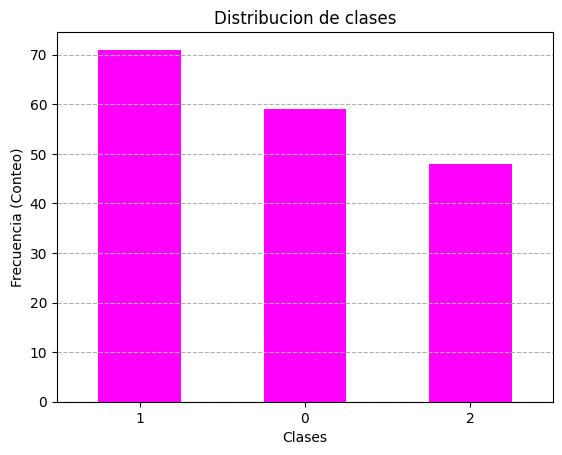


Matriz de correlacion:


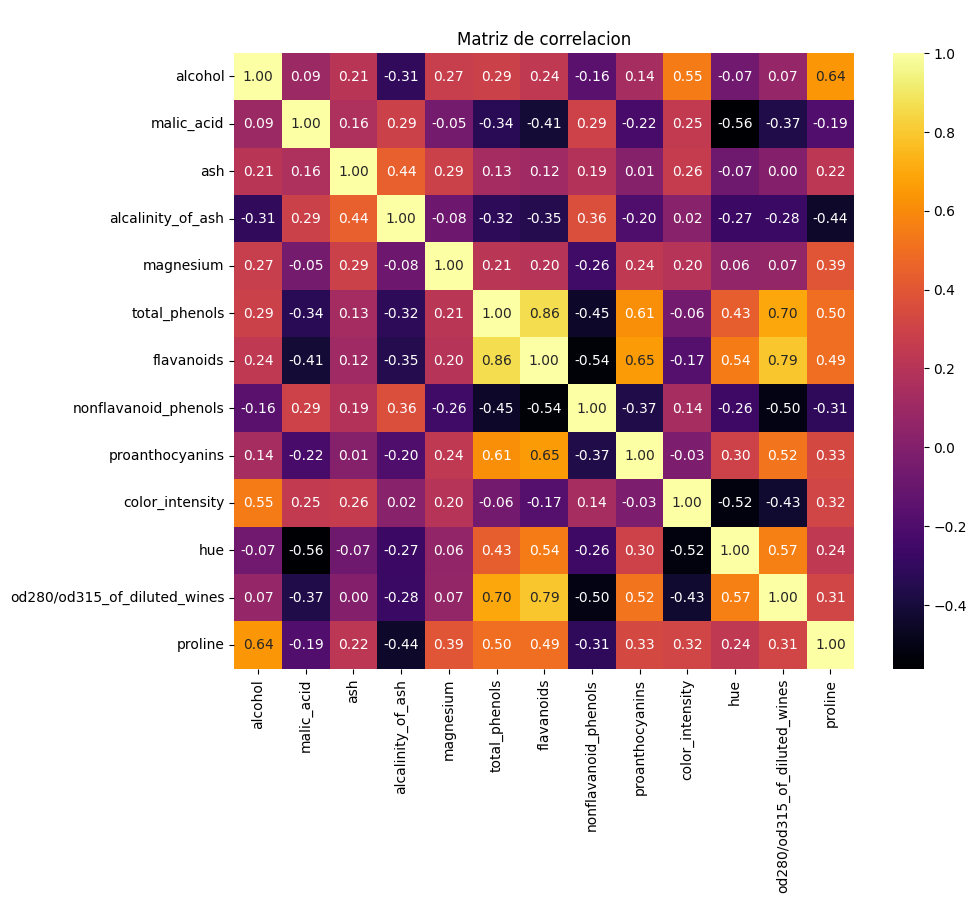

Correlación de las Características con la Clase de Vino (Target):
target                          1.000000
flavanoids                      0.847498
od280/od315_of_diluted_wines    0.788230
total_phenols                   0.719163
proline                         0.633717
hue                             0.617369
alcalinity_of_ash               0.517859
proanthocyanins                 0.499130
nonflavanoid_phenols            0.489109
malic_acid                      0.437776
alcohol                         0.328222
color_intensity                 0.265668
magnesium                       0.209179
ash                             0.049643
Name: target, dtype: float64
Histogramas de las caracteristicas principales


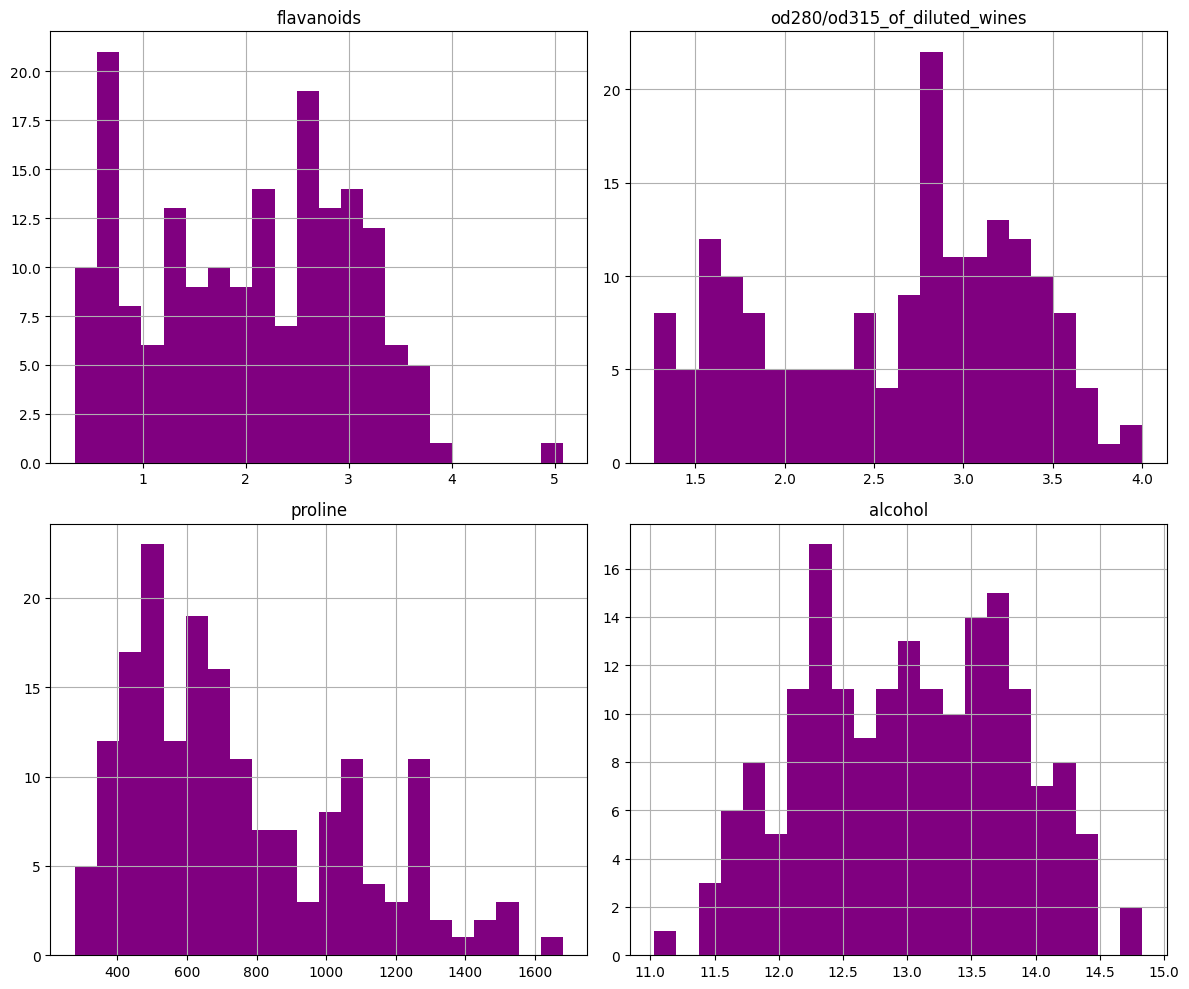

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_wine

df_wine=load_wine()

df=pd.DataFrame(data=df_wine.data, columns=df_wine.feature_names)
df['target']=df_wine.target
print(df.head())
print("\n")
print(df.info())
distribution = df['target'].value_counts()

print("\nDistribucion de clases:")
print(distribution)
distribution.plot(kind='bar', title='Distribucion de clases', color='magenta')
plt.xlabel('Clases')
plt.ylabel('Frecuencia (Conteo)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

main_features = df.drop('target', axis=1)
correlation_matrix = main_features.corr()
print("\nMatriz de correlacion:")
#mata de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', fmt=".2f")
plt.title('\nMatriz de correlacion')
plt.show()

print("Correlación de las Características con la Clase de Vino (Target):")

correlations_with_target = df.corr()['target']
sorted_correlations = correlations_with_target.abs().sort_values(ascending=False)
print(sorted_correlations)

main_features=df[['flavanoids','od280/od315_of_diluted_wines','proline','alcohol']]
print("Histogramas de las caracteristicas principales")
main_features.hist(bins=22, figsize=(12, 10), color='purple')
plt.tight_layout()
plt.show()

Las caracteristicas mas importantes tomando unicamente en cuenta el mapa de calor serian:
* flavanoids y 	total_phenols con correlacion positiva de	0.86
* flavanoids y od280/od315_of_diluted_wines  s con correlacion positiva de	0.79
* Alcohol y	proline con una correlacion positiva de 0.64

Si tomamos en cuenta la variable objetivo serian:
* flavanoids                      0.847498
* od280/od315_of_diluted_wines    0.788230
* total_phenols                   0.719163
* proline                         0.633717
* hue                             0.617369

Tanto flavanoids como total_phenols tienen una correlacion fuerte entre ellas y el modelo por lo que podria indicar redundandias en el modelo por lo tanyo solo se tomara en cuenta flavanoids, de manera que solo se graficarion flavanoids, od280/od315_of_diluted_wines, proline y alcohol.

Aunque se entrenara el modelo usando todas.

#2. **Entrenamiento base con SVM**

   - Usa un modelo SVM con kernel RBF.
   - Aplica `StratifiedKFold` con 5 particiones.
   - Evalúa con métricas por clase: precisión, recall, F1-score.
   - Calcula y reporta métricas promedio y por clase.




In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X=df.drop('target', axis=1)
y=df['target']
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
class_names = [str(i) for i in np.unique(y)]
reports = []
average_cm = np.zeros((3, 3), dtype=np.float32)

for train_index, test_index in skf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  svm_model.fit(X_train, y_train)


  y_pred = svm_model.predict(X_test)
  cm_fold = confusion_matrix(y_test, y_pred)
  average_cm += cm_fold
  report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
  reports.append(report_dict)
  metrics_df = pd.DataFrame()

for report in reports:
    df_fold = pd.DataFrame(report).transpose()
    metrics_df = pd.concat([metrics_df, df_fold])

avg_metrics = metrics_df.groupby(metrics_df.index).mean()
final_report_df = avg_metrics[['precision', 'recall', 'f1-score']].loc[class_names + ['accuracy', 'macro avg', 'weighted avg']]
print("Reporte de Métricas Promedio (5 Folds):")
print(final_report_df.round(3))

Reporte de Métricas Promedio (5 Folds):
              precision  recall  f1-score
0                 1.000   0.983     0.991
1                 0.972   0.986     0.979
2                 0.982   0.980     0.980
accuracy          0.983   0.983     0.983
macro avg         0.985   0.983     0.983
weighted avg      0.984   0.983     0.983


#3. **Análisis del problema de desbalance**

- Interpreta las métricas: ¿qué clase tiene peor desempeño? ¿por qué?

**La clase que tiene el peor desempeño es la clase 1 debido a que el f1 score muestra el menor porcentaje de aciertos al clasificar. Esto puede deberse a factores como:**
* **El desbalance del dataset, la clase 1 con 71 apariciones puede confundir al modelo.**
* **Las caracteristicas de esa clase pueden opacar o sobreponerse a las otras 2**


   - Reporta matriz de confusión promedio.

In [86]:
average_cm /= N_SPLITS
cm_df = pd.DataFrame(average_cm, index=class_names, columns=class_names)
print("\nMatriz de Confusión Promedio:")
print(cm_df)



Matriz de Confusión Promedio:
      0     1     2
0  2.32  0.04  0.00
1  0.00  2.80  0.04
2  0.00  0.04  1.88


#4. **Aplicación de SMOTE**


   - Aplica `SMOTE` solo al conjunto de entrenamiento dentro de cada fold.
   - Entrena nuevamente la SVM.
   - Compara métricas antes y después.

In [125]:
from imblearn.over_sampling import SMOTE
from collections import defaultdict
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import ADASYN

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
smote_sampler = SMOTE(random_state=42)
smote_reports = []

for train_index, test_index in skf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train_smote, y_train_smote = smote_sampler.fit_resample(X_train, y_train)

  svm_model.fit(X_train_smote, y_train_smote)
  y_pred = svm_model.predict(X_test)
  report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
  smote_reports.append(report_dict)

metrics_df_smote = pd.DataFrame()
for report in smote_reports:
    df_fold = pd.DataFrame(report).transpose()
    metrics_df_smote = pd.concat([metrics_df_smote, df_fold])


avg_metrics_smote = metrics_df_smote.groupby(metrics_df_smote.index).mean()
final_report_smote = avg_metrics_smote[['precision', 'recall', 'f1-score']].round(3)
data_original = final_report_df.round(3)


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))
oss_sampler = OneSidedSelection(random_state=42)
oss_reports = []

for train_index, test_index in skf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train_oss, y_train_oss = oss_sampler.fit_resample(X_train, y_train)
  svm_model.fit(X_train_oss, y_train_oss)
  y_pred = svm_model.predict(X_test)
  report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
  oss_reports.append(report_dict)

metrics_df_oss = pd.DataFrame()
for report in oss_reports:
  df_fold = pd.DataFrame(report).transpose()
  metrics_df_oss = pd.concat([metrics_df_oss, df_fold])

avg_metrics_oss = metrics_df_oss.groupby(metrics_df_oss.index).mean()
final_report_oss = avg_metrics_oss[['precision', 'recall', 'f1-score']].round(3)

adasyn_sampler = ADASYN(random_state=42)
adasyn_reports = []
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  X_train_adasyn, y_train_adasyn = adasyn_sampler.fit_resample(X_train, y_train)
  svm_model.fit(X_train_adasyn, y_train_adasyn)
  y_pred = svm_model.predict(X_test)
  report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
  adasyn_reports.append(report_dict)
metrics_df_adasyn = pd.DataFrame()
for report in adasyn_reports:
  df_fold = pd.DataFrame(report).transpose()
  metrics_df_adasyn = pd.concat([metrics_df_adasyn, df_fold])

avg_metrics_adasyn = metrics_df_adasyn.groupby(metrics_df_adasyn.index).mean()
final_report_adasyn = avg_metrics_adasyn[['precision', 'recall', 'f1-score']].round(3)

comparison_df = pd.concat(
    [data_original, final_report_smote, final_report_oss, final_report_adasyn],
    keys=['Original (Sin SMOTE)', 'Con SMOTE', 'Con OSS', 'Con ADASYN'],
    axis=1
)

print("\nReporte de Métricas Promedio (5 Folds)\n")
print(comparison_df.round(3))



Reporte de Métricas Promedio (5 Folds)

             Original (Sin SMOTE)                 Con SMOTE                  \
                        precision recall f1-score precision recall f1-score   
0                           1.000  0.983    0.991     1.000  0.983    0.991   
1                           0.972  0.986    0.979     0.972  0.986    0.979   
2                           0.982  0.980    0.980     0.982  0.980    0.980   
accuracy                    0.983  0.983    0.983     0.983  0.983    0.983   
macro avg                   0.985  0.983    0.983     0.985  0.983    0.983   
weighted avg                0.984  0.983    0.983     0.984  0.983    0.983   

               Con OSS                 Con ADASYN                  
             precision recall f1-score  precision recall f1-score  
0                1.000  0.895    0.942      1.000  0.983    0.991  
1                0.914  0.986    0.947      0.972  0.986    0.979  
2                0.982  0.980    0.980      0.982  0.9

#5. **Visualización y conclusiones**

   - Usa un gráfico de barras comparando F1 por clase antes y después.
  

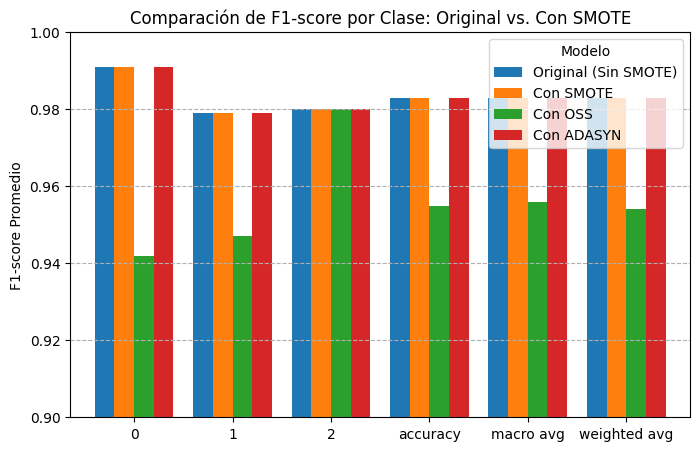

In [126]:
# Creando un DataFrame para la visualización de la comparación
df_plot = comparison_df.loc[:, pd.IndexSlice[:, 'f1-score']]
df_plot.columns = df_plot.columns.get_level_values(0)

df_plot.plot(kind='bar', figsize=(8, 5), width=0.8)
plt.title('Comparación de F1-score por Clase: Original vs. Con SMOTE')
plt.ylabel('F1-score Promedio')
plt.ylim(0.9, 1.00)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Modelo')
plt.show()

 - Comenta las ventajas y riesgos de aplicar SMOTE con SVM.

**SMOTE nos ayuda a trabajar con datasets que contienen clases que no se encuentran balanceadas, por ejemplo en el dataset del vino donde cada clase tiene una cantidad diferente de frecuencias.**

**Entre sus ventajas se encuentra el hecho distribuye en el enfoque del modelo minimizando la inclinacion por una clase en particular. Sin embargo tambien es posible que al intentar "llenar o complementar" el balance, genere ruido o datos  basura en el dataset lo que eventualmente cause estragos en el modelo.**


**Ademas puede causar un overfitting en el modelo identificando patrones fantasma.**


- Explica cuándo conviene usar otras técnicas como `One-Sided Selection` o `ADASYN`.

Los casos donde SMOTE no es suficiente (o los resultados no son enteramente satisfactorios) pero es necesario que el entrenamiento del modelo sea rapido se debe OSS ya que su funcion se centra en eliminar datos inutiles o duplicados en la clase mas grande. Pero es posible (Como en este ejercicio) que debido a los datos eliminados el resultado del modelo empeore.

Mientras que ADASYN se utiliza cuando las clases tienen caracteristicas mezcladas entre si y es necesario "mejorar o complementar" las caracterisiticas con poblaciones menores o "minorias" ya que se centra en generar datos sinteticos para las areas donde sea necesario.



#Conclusiones finales


* **El mejor modelo:** El modelo SVM Originalfue la mejor opción, alcanzando una exactitud (Accuracy) promedio de 0.983.
* **Clase Más Débil:** La Clase 1 presentó el desempeño más bajo (F1-score de 0.979), siendo ligeramente más propensa a Falsos Positivos en la frontera de decisión.
* **Ineficacia:** Las técnicas SMOTE y ADASYN produjeron métricas idénticas al modelo Original. Esto prueba que el dataset es altamente separable y que la falta de balance de clases no era el problema real.
* **Riesgos:** La técnica OSS empeoró significativamente el rendimiento (Accuracy cayó a $0.955$), ya que eliminó información del dataset, afectando notablemente el Recall de la Clase 0.
* **Conclusion: **La totalidad de los datos originales era necesaria y suficiente. Cualquier intento de añadir datos sintéticos o eliminarlos resultó ser inútil o perjudicial para el rendimiento del SVM.
